## imports

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier



## helpful functions

In [2]:
def get_missingness(dframe):
    missing_columns = []
    for column in dframe.columns:
        na_perc=np.sum(dframe[column].isna())/dframe.shape[0]
        print(column, na_perc)
        if na_perc>0.2:
            print(f"\n{column} missingness too high ({round(na_perc,3)*100}%)\n")
            missing_columns.append(column)
    return missing_columns

def group_features(dframe,target):
    non_ml_attr=[]
    nominal_attr = []
    numerical_attr = []

    print("Column\t\tuniqueness\tdatatype")


    for column in dframe.loc[:, dframe.columns != target].columns: #get all columns except for the target column
        n_unique = len(dframe[column].unique())
        p_unique = round(n_unique/dframe.shape[0]*100,3)
        c_type = dframe.dtypes[column]
        print(f"{column}\t\t{p_unique}%\t\t{c_type}")

        if dframe[column].dtype == pd.api.types.pandas_dtype('int64') and p_unique > 99:
            print(f"\nPotential ID, inspect {column}\n")
            non_ml_attr.append(column)
        
        elif dframe[column].dtype == pd.api.types.pandas_dtype(object):
            nominal_attr.append(column)
        
        else:
            numerical_attr.append(column)

    print(f"\n\nNon ML Attribute list:\t\t{non_ml_attr}")
    print(f"Numerical Attributes:\t\t{numerical_attr}")
    print(f"Nominal Attributes:\t\t{nominal_attr}")

    return non_ml_attr, numerical_attr, nominal_attr

def get_x_y(dframe,target):
    x = dframe.loc[:, dframe.columns != target]
    y = dframe[target].values.ravel()

    return x,y


def false_discovery_test(model,train,val,target,n_bootstraps=20):
    
    bootstrapped_unscrambled = []
    bootstrapped_scrambled = []
    
    for i in range(n_bootstraps):
        #bootstrap samples from the train set
        boot_train = resample(train, replace=True, random_state=i, stratify=train[target]) 
        boot_train_x, boot_train_y = get_x_y(boot_train,target)

        boot_val = resample(val, replace=True, random_state=i, stratify=val[target]) 
        boot_val_x, boot_val_y = get_x_y(boot_val, target)

        #fit the model to the unscrambled bootstrapped sample
        model.fit(boot_train_x,boot_train_y)
        #predict the validation datapoints using the unscrambled bootstrap sample
        boot_val_pred_y = model.predict(boot_val_x)
        #add the unscrambled validation score (RMSE) to the unscrambled list
        bootstrapped_unscrambled.append(average_precision_score(boot_val_y, boot_val_pred_y))

        #scramble the boot_y_df
        scrambled_boot_train_y = shuffle(boot_train_y, random_state=i)#.values.ravel(), random_state = i)
        #fit the model to the scrambled data
        model.fit(boot_train_x,scrambled_boot_train_y)
        #predict using the scrambled model
        boot_val_pred_y_scrambled = model.predict(boot_val_x)
        #add the scrambled validation score to the scrambled list
        bootstrapped_scrambled.append(average_precision_score(boot_val_y,boot_val_pred_y_scrambled))
    

    unscrambled = bootstrap((bootstrapped_unscrambled,),np.mean,confidence_level=0.95, random_state=42)
    scrambled = bootstrap((bootstrapped_scrambled,),np.mean,confidence_level=0.95, random_state=42)

    fig, ax = plt.subplots()
    ax.hist(unscrambled.bootstrap_distribution, bins=25, label='Unscrambled', alpha = 0.5)
    ax.hist(scrambled.bootstrap_distribution, bins=25, label='Scrambled', alpha = 0.5)
    ax.set_title('Bootstrap Distribution')
    ax.set_xlabel('Average Precision Score')
    ax.set_ylabel('frequency')
    fig.legend(loc='upper right')
    plt.show()
    
    print("Unscrambled 95% confidence interval: ",unscrambled.confidence_interval)
    print("Scrambled 95% confidence interval: ",scrambled.confidence_interval)

def boot_val(model,val,target, n_bootstraps=20):
    df_name = test(val)
    print(f'\n{df_name} Statistic Score: Average Precision\nConfidence Interval: 95%')
    t_score = []
    for i in range(n_bootstraps):
        boot_val = resample(val, replace=True, random_state=i, stratify=val[target])
        
        boot_x, boot_y = get_x_y(boot_val, target)

        boot_pred = model.predict(boot_x)

        t_score.append(average_precision_score(boot_y,boot_pred))
    
    bci = bootstrap((t_score,), np.mean, confidence_level=0.95, random_state=42)
    print('\tBootstrapped Statistic: ',bci.confidence_interval)
    return bci

    
#stolen from here: https://stackoverflow.com/questions/41684553/print-dataframe-name
def test(data):
    name =[x for x in globals() if globals()[x] is data][0]
    return name

def tar_bal(tar):
    print(f"Class 1 %: {sum(tar)/len(tar):.3f}")


## parameters

In [3]:
target = 'y'

testing =False
frac = 0.1 #this is the fraction of the train set used when testing is set to true

## script run time - start timer

In [4]:
start = time.time()

## load the data

In [5]:
data = pd.read_csv('data_set_1.csv')
print(data.shape)
print(f"Class 1 %: {np.sum(data[target])/data.shape[0]*100:.3f}")

(50000, 13)
Class 1 %: 14.846


## drop observations with nans in the target attribute

In [6]:
data2 = data[data[target].notna()] 
print(data2.shape)
print(f"Class 1 %: {np.sum(data2[target])/data2.shape[0]*100:.3f}")
# data = data[data[]]
# master = master[master['avg_temp_c'].notna()]


(49503, 13)
Class 1 %: 14.995


## train/test/val split
test size = 20% of 100% = 20%<br>
train size = 75% of 80% = 60%<br>
val size = 25% of 80% = 20%

In [7]:
train_df, test_df = train_test_split(data2, test_size=0.2, random_state=42, stratify=data2[target])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df[target])

print(f"Train size:\t\t{train_df.shape}\tTrain Class 1%: {np.sum(train_df[target])/train_df.shape[0]}")
print(f"Validation Size:\t{val_df.shape}\tValidation Class 1%: {np.sum(val_df[target])/val_df.shape[0]}")
print(f"Test Size:\t\t{test_df.shape}\tTest Class 1%: {np.sum(test_df[target])/test_df.shape[0]}")

Train size:		(29701, 13)	Train Class 1%: 0.14992761186492037
Validation Size:	(9901, 13)	Validation Class 1%: 0.14998485001515
Test Size:		(9901, 13)	Test Class 1%: 0.14998485001515


## configure machine learning attributes

### check for high missingness
dropping high missingness here

In [8]:
missing_columns = []
for column in train_df.columns:
    na_perc=np.sum(train_df[column].isna())/train_df.shape[0]
    print(column, na_perc)
    if na_perc>0.2:
        print(f"\nDropping {column}, missingness too high ({round(na_perc,3)*100}%)\n")
        train_df=train_df.drop(column, axis=1)
        missing_columns.append(column)

attr_0 0.0
attr_1 0.029224605232147066
attr_2 0.009561967610518165
attr_3 0.0
attr_4 0.1046092724150702
attr_5 0.0
attr_6 0.048920911753813
attr_7 0.0
attr_8 0.32884414666172856

Dropping attr_8, missingness too high (32.9%)

attr_9 0.018787246220665972
attr_10 0.04925760075418336
attr_11 0.08801050469681156
y 0.0


### identify non machine learning attributes
### get attributes by dtypes
### machine learning attribute configuration

In [9]:
non_ml_attr=[]
nominal_attr = []
numerical_attr = []

print("Column\t\tuniqueness\tdatatype")


for column in train_df.columns[:-1]:
    n_unique = len(train_df[column].unique())
    p_unique = round(n_unique/train_df.shape[0]*100,3)
    c_type = train_df.dtypes[column]
    print(f"{column}\t\t{p_unique}%\t\t{c_type}")

    if train_df[column].dtype == pd.api.types.pandas_dtype('int64') and p_unique > 99:
        print(f"\nPotential ID, inspect {column}\n")
        non_ml_attr.append(column)
    
    elif train_df[column].dtype == pd.api.types.pandas_dtype(object):
        nominal_attr.append(column)
    
    else:
        numerical_attr.append(column)
        #could catch numeric categories here, int values that aren't 99+% unique, but shouldn't be considered numeric. looks like we won't catch them on this dataset

print(f"\n\nHigh Missingness Drop List:\t{missing_columns}")
print(f"Non ML Attribute list:\t\t{non_ml_attr}")
print(f"Numerical Attributes:\t\t{numerical_attr}")
print(f"Nominal Attributes:\t\t{nominal_attr}")


Column		uniqueness	datatype
attr_0		100.0%		int64

Potential ID, inspect attr_0

attr_1		97.081%		float64
attr_2		0.01%		object
attr_3		100.0%		float64
attr_4		89.542%		float64
attr_5		100.0%		float64
attr_6		95.111%		float64
attr_7		100.0%		float64
attr_9		98.125%		float64
attr_10		95.078%		float64
attr_11		91.202%		float64


High Missingness Drop List:	['attr_8']
Non ML Attribute list:		['attr_0']
Numerical Attributes:		['attr_1', 'attr_3', 'attr_4', 'attr_5', 'attr_6', 'attr_7', 'attr_9', 'attr_10', 'attr_11']
Nominal Attributes:		['attr_2']


### Drop non ml attributes
dropping attributes that look like ID's here

In [10]:
print(train_df.shape)
train_df = train_df.drop(non_ml_attr, axis=1)
print(train_df.shape)


(29701, 12)
(29701, 11)


### identify attributes that were candidates for machine learning but you have chosen to eliminate from machine learning - feature selection
<br>
drop attributes from the test and validation sets as well

In [11]:
dropped_columns = non_ml_attr + missing_columns
print(f"Dropped the following columns based on missingness and uniqueness+data type: {dropped_columns}")

val_df = val_df.drop(dropped_columns, axis=1)
test_df = test_df.drop(dropped_columns, axis=1)


Dropped the following columns based on missingness and uniqueness+data type: ['attr_0', 'attr_8']


In [12]:
assert len(data.columns) == len(nominal_attr+numerical_attr+dropped_columns)+1 #+1 for target
assert np.all(train_df.columns == test_df.columns)
assert np.all(train_df.columns == val_df.columns)

## check out the label

count    29701.000000
mean         0.149928
std          0.357006
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: y, dtype: float64

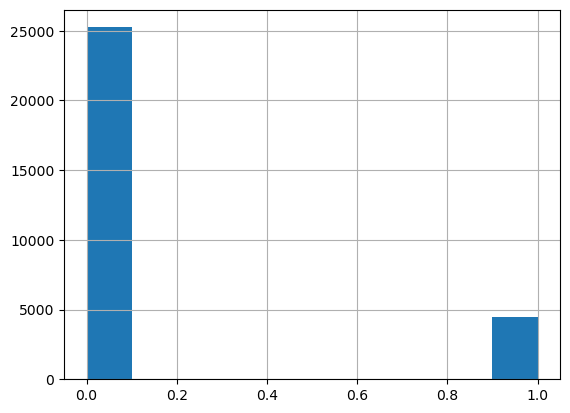

In [13]:
assert train_df[target].dtype == pd.api.types.pandas_dtype(float) or train_df[target].dtype == pd.api.types.pandas_dtype('int64')
assert train_df[target].median()==0 or train_df[target].median()==1
#these assertions should hold for any numeric binary target with 0's and 1's
train_df[target].hist()
train_df[target].describe()

## build the preprocessing pipeline

In [14]:
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='mean')), 
           ("scaler", StandardScaler())]
)

nominal_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), 
           ('target_encoder', TargetEncoder(target_type='continuous', random_state=42)),
           ("scaler", StandardScaler())
          ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_attr),
        ('nominal', nominal_transformer, nominal_attr)
    ]
)

## define default estimators

In [15]:
sgd = SGDClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
lr = LogisticRegression(random_state=42)

pipe = Pipeline([('preprocessor', preprocessor),('model',sgd)])

sgd_params = {}
sgd_params['model'] = [sgd]
sgd_params['model__random_state'] = [42]

rf_params = {}
rf_params['model'] = [rf]
rf_params['model__random_state'] = [42]


gb_params = {}
gb_params['model'] = [gb]
gb_params['model__random_state'] = [42]

lr_params = {}
lr_params['model'] = [lr]
lr_params['model__random_state'] = [42]


params = [sgd_params, rf_params, gb_params, lr_params]

## build the composite estimator

In [16]:
default_grid = GridSearchCV(pipe,params, scoring='average_precision',return_train_score=True, verbose = 4)

In [17]:
#If we're trying to do fast development we will edit the train and val set to be smaller
if testing:
    print('Train shape before resample: ',train_df.shape)
    print('Validation shape before resample: ',val_df.shape)

    train_df = resample(train_df, replace=False, n_samples = (round(train_df.shape[0]*frac)), stratify=train_df[target], random_state=42)
    val_df = resample(val_df, replace=False, n_samples = (round(val_df.shape[0]*frac)), stratify=val_df[target], random_state=42)

    print('Train shape after resample: ',train_df.shape)
    print('Validaiton shape after resample: ',val_df.shape)

## default model survey

### train the default model

In [19]:
train_x, train_y = get_x_y(train_df,target)

default_grid.fit(train_x,train_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END model=SGDClassifier(random_state=42), model__random_state=42;, score=(train=0.772, test=0.763) total time=   0.0s
[CV 2/5] END model=SGDClassifier(random_state=42), model__random_state=42;, score=(train=0.788, test=0.789) total time=   0.0s
[CV 3/5] END model=SGDClassifier(random_state=42), model__random_state=42;, score=(train=0.796, test=0.809) total time=   0.0s
[CV 4/5] END model=SGDClassifier(random_state=42), model__random_state=42;, score=(train=0.788, test=0.789) total time=   0.0s
[CV 5/5] END model=SGDClassifier(random_state=42), model__random_state=42;, score=(train=0.792, test=0.784) total time=   0.0s
[CV 1/5] END model=RandomForestClassifier(random_state=42), model__random_state=42;, score=(train=1.000, test=0.938) total time=  13.5s
[CV 2/5] END model=RandomForestClassifier(random_state=42), model__random_state=42;, score=(train=1.000, test=0.950) total time=  13.3s
[CV 3/5] END model=RandomForestCl

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['attr_1',
                                                                          'attr_3',
                                                                          'attr_4',
                                                                          'attr_5',
                                                                          'attr_6',
                                                                          'attr_7',
                                                                          'attr_9',
                                                                          'attr_10',
                                                                          'attr_11']),
                                                                        ('nominal',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('target_en...
             param_grid=[{'model': [SGDClassifier(random_state=42)],
                          'model__random_state': [42]},
                         {'model': [RandomForestClassifier(random_state=42)],
                          'model__random_state': [42]},
                         {'model': [GradientBoostingClassifier(random_state=42)],
                          'model__random_state': [42]},
                         {'model': [LogisticRegression(random_state=42)],
                          'model__random_state': [42]}],
             return_train_score=True, scoring='average_precision', verbose=4)

In [20]:
compare_default_df = pd.DataFrame(default_grid.cv_results_)
compare_default_df[['param_model','mean_train_score','mean_test_score','std_train_score','std_test_score','rank_test_score']].sort_values('rank_test_score')

,param_model,mean_train_score,mean_test_score,std_train_score,std_test_score,rank_test_score
1,RandomForestClassifier(random_state=42),0.999988,0.947386,0.000006,0.005326,1
2,GradientBoostingClassifier(random_state=42),0.938619,0.919257,0.002062,0.005712,2
3,LogisticRegression(random_state=42),0.789415,0.789233,0.001975,0.006177,3
0,SGDClassifier(random_state=42),0.787265,0.786934,0.008095,0.014886,4


### evaluate the default model on the validation set by bootstrapping without refit - get the low and high limits

In [21]:
default_val = boot_val(default_grid.best_estimator_,val_df,target)


val_df Statistic Score: Average Precision
Confidence Interval: 95%
	Bootstrapped Statistic:  ConfidenceInterval(low=0.7664642513656613, high=0.7745767238215573)


### Why is it so much lower than the test scores I see in the CV results? 
I thought cross validation is able to validate similarly to this bootstrap method. <br>
Here's how I understand it:<br><br>
**the bootstrapping method, without refit: take unseen data, predict on the unseen features, compare those predictions to the unseen true values<br><br>
**cross validation: take unseen data (the left out fold), predict on it, compare those predictions to the unseen true values (left out fold values)<br>
 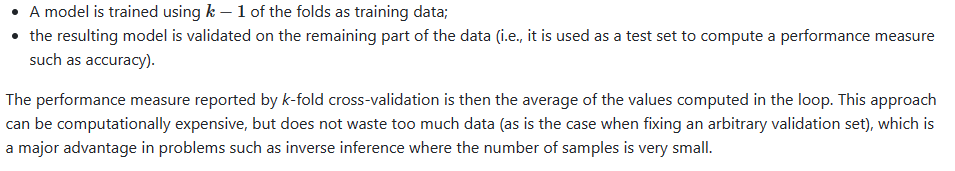

 <br>
 <br>
 the main difference with the bootstrapping method is it takes many random samples with replacement from the validation set. We do this so we can get a confidence interval on unseen data predictions<br>
 but doesn't CV kind of do this too? For each iteration, there is a validation fold, and we get the average test score by averageing over the folds. If the number of folds is equal to the number of bootstrap samples, wouldn't we get something similar? 

In [22]:
val_x, val_y = get_x_y(val_df,target)
val_pred = default_grid.best_estimator_.predict(val_x)
print(f"Validation average precision score without bootstraping: {average_precision_score(val_y, val_pred)}")#, average='samples')

pred_y = default_grid.best_estimator_.predict(train_x)
print(f"Train average precision score without bootstrapping: {average_precision_score(train_y,pred_y)}")

Validation average precision score without bootstraping: 0.7707530275082423
Train average precision score without bootstrapping: 0.997990459512588


In [23]:
cv_results = cross_validate(default_grid.best_estimator_, train_x, train_y, scoring = 'average_precision', return_train_score=True)
round(np.mean(cv_results['test_score']),5)

0.94739

In [24]:
#false_discovery_test(default_grid.best_estimator_,train_df,val_df,target)

## tune two estimator hyperparameters - you will not be tuning the preprocessing stage in this round of experimentation

### set up the hyperparameter grid

In [25]:
best_est = default_grid.best_estimator_
default_grid.best_params_

{'model': RandomForestClassifier(random_state=42), 'model__random_state': 42}

In [26]:
rf_params = {}
rf_params['model'] = [rf]
#rf_params['model__random_state'] = [42]
rf_params['model__n_estimators'] = [10,100,500]
rf_params['model__class_weight'] = [None,'balanced']
#rf_params['model__max_features'] = ['sqrt',2,None]

sgd_params = {}
sgd_params['model'] = [sgd]
sgd_params['model__class_weight'] = [None,'balanced']
sgd_params['model___loss'] = ['log_loss','hinge',',modified_huber']

gb_params = {}
gb_params['model'] = [gb]
gb_params['model__n_estimators'] = [10,100,500]
gb_params['model__max_depth'] = [3,5,8]

lr_params = {}
lr_params['model'] = [lr]
lr_params['model__penalty'] = ['elasticnet','l2','l1']
lr_params['model__class_weight'] = [None,'balanced']



models = [rf_params, sgd_params, gb_params, lr_params]
for model in models:
    if type(model['model'][0]).__name__ == type(default_grid.best_estimator_.named_steps['model']).__name__:
        params = [model]
        print(f'Conducting Grid Search on the following model with the following parameters:')
        print('\n\t',params,'\n\n')
        break

tuned_grid = GridSearchCV(pipe,params, scoring='average_precision',return_train_score=True, verbose = 4)
tuned_grid.fit(train_x,train_y)


Conducting Grid Search on the following model with the following parameters:

	 [{'model': [RandomForestClassifier(random_state=42)], 'model__n_estimators': [10, 100, 500], 'model__class_weight': [None, 'balanced']}] 


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END model=RandomForestClassifier(random_state=42), model__class_weight=None, model__n_estimators=10;, score=(train=0.998, test=0.904) total time=   1.3s
[CV 2/5] END model=RandomForestClassifier(random_state=42), model__class_weight=None, model__n_estimators=10;, score=(train=0.999, test=0.916) total time=   1.2s
[CV 3/5] END model=RandomForestClassifier(random_state=42), model__class_weight=None, model__n_estimators=10;, score=(train=0.999, test=0.921) total time=   1.2s
[CV 4/5] END model=RandomForestClassifier(random_state=42), model__class_weight=None, model__n_estimators=10;, score=(train=0.999, test=0.918) total time=   1.2s
[CV 5/5] END model=RandomForestClassifier(random_state=42), model__class

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['attr_1',
                                                                          'attr_3',
                                                                          'attr_4',
                                                                          'attr_5',
                                                                          'attr_6',
                                                                          'attr_7',
                                                                          'attr_9',
                                                                          'attr_10',
                                                                          'attr_11']),
                                                                        ('nominal',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('target_en...
                                                                                          TargetEncoder(random_state=42,
                                                                                                        target_type='continuous')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['attr_2'])])),
                                       ('model',
                                        SGDClassifier(random_state=42))]),
             param_grid=[{'model': [RandomForestClassifier(n_estimators=500,
                                                           random_state=42)],
                          'model__class_weight': [None, 'balanced'],
                          'model__n_estimators': [10, 100, 500]}],
             return_train_score=True, scoring='average_precision', verbose=4)

### examine the best hyperparameters from the GridSearchCV - make sure your hyperparameter grid was well designed to give your model a chance to explore the hyperparameter space

In [27]:
compare_tuned_df = pd.DataFrame(tuned_grid.cv_results_)

compare_tuned_df[['param_model','mean_train_score','mean_test_score','std_train_score','std_test_score','rank_test_score']].sort_values('rank_test_score')

,param_model,mean_train_score,mean_test_score,std_train_score,std_test_score,rank_test_score
2,"RandomForestClassifier(n_estimators=500, rando...",0.999996,0.949994,0.000003,0.005242,1
1,"RandomForestClassifier(n_estimators=500, rando...",0.999988,0.947386,0.000006,0.005326,2
5,"RandomForestClassifier(n_estimators=500, rando...",0.999998,0.945124,0.000002,0.005455,3
4,"RandomForestClassifier(n_estimators=500, rando...",0.999992,0.942446,0.000005,0.004582,4
0,"RandomForestClassifier(n_estimators=500, rando...",0.998784,0.914219,0.000185,0.005766,5
3,"RandomForestClassifier(n_estimators=500, rando...",0.998683,0.904087,0.000211,0.008629,6


In [28]:
import pprint
pprint.pprint(tuned_grid.best_params_)

{'model': RandomForestClassifier(n_estimators=500, random_state=42),
 'model__class_weight': None,
 'model__n_estimators': 500}


In [29]:
rf_params = {}
rf_params['model'] = [rf]
#rf_params['model__random_state'] = [42]
rf_params['model__n_estimators'] = [10,100,500]
rf_params['model__max_depth'] = [3]
rf_params['model__max_features'] = ['sqrt',2,None]

params = [rf_params]
tuned_grid2 = GridSearchCV(pipe,params, scoring='average_precision',return_train_score=True, verbose = 4)
tuned_grid2.fit(train_x,train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END model=RandomForestClassifier(n_estimators=500, random_state=42), model__max_depth=3, model__max_features=sqrt, model__n_estimators=10;, score=(train=0.811, test=0.778) total time=   0.3s
[CV 2/5] END model=RandomForestClassifier(n_estimators=500, random_state=42), model__max_depth=3, model__max_features=sqrt, model__n_estimators=10;, score=(train=0.795, test=0.793) total time=   0.3s
[CV 3/5] END model=RandomForestClassifier(n_estimators=500, random_state=42), model__max_depth=3, model__max_features=sqrt, model__n_estimators=10;, score=(train=0.795, test=0.788) total time=   0.3s
[CV 4/5] END model=RandomForestClassifier(n_estimators=500, random_state=42), model__max_depth=3, model__max_features=sqrt, model__n_estimators=10;, score=(train=0.798, test=0.791) total time=   0.3s
[CV 5/5] END model=RandomForestClassifier(n_estimators=500, random_state=42), model__max_depth=3, model__max_features=sqrt, model__n_estimat

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['attr_1',
                                                                          'attr_3',
                                                                          'attr_4',
                                                                          'attr_5',
                                                                          'attr_6',
                                                                          'attr_7',
                                                                          'attr_9',
                                                                          'attr_10',
                                                                          'attr_11']),
                                                                        ('nominal',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('target_en...
                                                                                                        target_type='continuous')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['attr_2'])])),
                                       ('model',
                                        SGDClassifier(random_state=42))]),
             param_grid=[{'model': [RandomForestClassifier(max_depth=3,
                                                           n_estimators=500,
                                                           random_state=42)],
                          'model__max_depth': [3],
                          'model__max_features': ['sqrt', 2, None],
                          'model__n_estimators': [10, 100, 500]}],
             return_train_score=True, scoring='average_precision', verbose=4)

In [30]:
compare_tuned_df2 = pd.DataFrame(tuned_grid2.cv_results_)

pprint.pprint(tuned_grid2.best_params_)

compare_tuned_df2[['param_model','mean_train_score','mean_test_score','std_train_score','std_test_score','rank_test_score']].sort_values('rank_test_score')

{'model': RandomForestClassifier(max_depth=3, n_estimators=500, random_state=42),
 'model__max_depth': 3,
 'model__max_features': 'sqrt',
 'model__n_estimators': 500}


,param_model,mean_train_score,mean_test_score,std_train_score,std_test_score,rank_test_score
2,"RandomForestClassifier(max_depth=3, n_estimato...",0.822723,0.813059,0.003056,0.011424,1
1,"RandomForestClassifier(max_depth=3, n_estimato...",0.815442,0.805444,0.006058,0.009220,2
4,"RandomForestClassifier(max_depth=3, n_estimato...",0.807063,0.795499,0.003192,0.010595,3
5,"RandomForestClassifier(max_depth=3, n_estimato...",0.805686,0.793915,0.002663,0.010425,4
0,"RandomForestClassifier(max_depth=3, n_estimato...",0.799673,0.788321,0.006073,0.005477,5
8,"RandomForestClassifier(max_depth=3, n_estimato...",0.790929,0.783701,0.004552,0.013922,6
7,"RandomForestClassifier(max_depth=3, n_estimato...",0.789319,0.781905,0.005236,0.011078,7
6,"RandomForestClassifier(max_depth=3, n_estimato...",0.765403,0.759165,0.011655,0.014878,8
3,"RandomForestClassifier(max_depth=3, n_estimato...",0.763388,0.753163,0.005595,0.014652,9


In [31]:
compare_tuned_df[['param_model','mean_train_score','mean_test_score','std_train_score','std_test_score','rank_test_score']].sort_values('rank_test_score')

,param_model,mean_train_score,mean_test_score,std_train_score,std_test_score,rank_test_score
2,"RandomForestClassifier(max_depth=3, n_estimato...",0.999996,0.949994,0.000003,0.005242,1
1,"RandomForestClassifier(max_depth=3, n_estimato...",0.999988,0.947386,0.000006,0.005326,2
5,"RandomForestClassifier(max_depth=3, n_estimato...",0.999998,0.945124,0.000002,0.005455,3
4,"RandomForestClassifier(max_depth=3, n_estimato...",0.999992,0.942446,0.000005,0.004582,4
0,"RandomForestClassifier(max_depth=3, n_estimato...",0.998784,0.914219,0.000185,0.005766,5
3,"RandomForestClassifier(max_depth=3, n_estimato...",0.998683,0.904087,0.000211,0.008629,6


### evaluate the tuned model on the validation set by bootstrapping without refit - get the low and high limits

In [32]:
tuned_model1 = tuned_grid.best_estimator_
tuned_model2 = tuned_grid2.best_estimator_

tuned1_val = boot_val(tuned_model1,val_df,target)
tuned1_train = boot_val(tuned_model1,train_df,target)

tuned2_val = boot_val(tuned_model2, val_df, target)
tuned2_train = boot_val(tuned_model2, train_df, target)


val_df Statistic Score: Average Precision
Confidence Interval: 95%
	Bootstrapped Statistic:  ConfidenceInterval(low=0.7667799122419299, high=0.776172341303905)

train_df Statistic Score: Average Precision
Confidence Interval: 95%
	Bootstrapped Statistic:  ConfidenceInterval(low=0.9995227529821834, high=0.9997518315507353)

val_df Statistic Score: Average Precision
Confidence Interval: 95%
	Bootstrapped Statistic:  ConfidenceInterval(low=0.3510894020771489, high=0.36221424667047736)

train_df Statistic Score: Average Precision
Confidence Interval: 95%
	Bootstrapped Statistic:  ConfidenceInterval(low=0.3773956692635467, high=0.3822118085952597)


In [33]:
if tuned1_val.bootstrap_distribution.mean() > tuned2_val.bootstrap_distribution.mean():
    tuned_model = tuned_model1
else:
    tuned_model = tuned_model2

## evaluate the tuned model on the test set by bootstrapping without refit - get the low and high limits

In [34]:
tuned_test = boot_val(tuned_model,test_df,target)


test_df Statistic Score: Average Precision
Confidence Interval: 95%
	Bootstrapped Statistic:  ConfidenceInterval(low=0.7932708847351811, high=0.7999760984369139)


In [35]:
print(f"Average Precision Score on 20 Bootstrapped Test Sets: {tuned_test.bootstrap_distribution.mean():.4f} +/- {tuned_test.standard_error:0.4f}")
print(f"95% Confidence interval: {tuned_test.confidence_interval[0]:0.4f} to {tuned_test.confidence_interval[1]:0.4f}")

Average Precision Score on 20 Bootstrapped Test Sets: 0.7967 +/- 0.0017
95% Confidence interval: 0.7933 to 0.8000


## check out script run time

In [36]:
end = time.time()
print(f'script run time: {(end - start)/60} minutes')

script run time: 29.68759631315867 minutes
